In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score,classification_report
from sklearn.pipeline import Pipeline



Read the dataset

In [416]:
path = '../Dataset/bank_customer.csv'
df = pd.read_csv(path)

In [417]:
df.head()

,Unnamed: 0,ID,Gender,Month_Income,Age,Region_Code,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,0,VBENBARO,Male,96345.0,29,254,Other,623,Yes,4,742366,X1,2,No
1,1,CCMEWNKY,Male,85640.0,43,268,Other,629,NaN,0,925537,X2,1,No
2,2,VK3KGA9M,Male,96345.0,31,270,Salaried,357,No,0,215949,X1,1,No
3,3,TT8RPZVC,Male,85640.0,29,272,Other,356,No,0,868070,X1,3,No
4,4,SHQZEYTZ,Female,42820.0,29,270,Other,572,No,0,657087,X1,3,No


Data Gathering and Exploration

In [418]:
df.duplicated().sum()

0

In [419]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             105000 non-null  int64  
 1   ID                     105000 non-null  object 
 2   Gender                 105000 non-null  object 
 3   Month_Income           102514 non-null  float64
 4   Age                    105000 non-null  int64  
 5   Region_Code            105000 non-null  int64  
 6   Occupation             102486 non-null  object 
 7   Credit_Score           105000 non-null  int64  
 8   Loan_Status            92511 non-null   object 
 9   Existing_Credit_Cards  105000 non-null  int64  
 10  Avg_Account_Balance    105000 non-null  int64  
 11  Account_Category       105000 non-null  object 
 12  Tenure_with_Bank       105000 non-null  int64  
 13  Lead_Outcome           105000 non-null  object 
dtypes: float64(1), int64(7), object(6)
m

In [420]:
missing_values = df.isna().sum().to_dict()

# Filter columns with missing values
columns_with_missing_values = {k: v for k, v in missing_values.items() if v > 0}

column_data_types = df.dtypes.to_dict()

numerical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] in ['int64', 'float64']}
categorical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] == 'object'}

print("Numerical columns with missing values:", numerical_missing)
print("Categorical columns with missing values:", categorical_missing)

Numerical columns with missing values: {'Month_Income': 2486}
Categorical columns with missing values: {'Occupation': 2514, 'Loan_Status': 12489}


Fill the missing values in the columns

In [421]:
# for column in categorical_missing:
#     if df[column].isnull().any():
#         df[column] = df[column].fillna(df[column].mode()[0])
    

In [422]:
# for column in numerical_missing:
#     if df[column].isnull().any():
#         df[column] = df[column].fillna(df[column].mean())

In [423]:
df = df.dropna()

In [424]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88143 entries, 0 to 104998
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             88143 non-null  int64  
 1   ID                     88143 non-null  object 
 2   Gender                 88143 non-null  object 
 3   Month_Income           88143 non-null  float64
 4   Age                    88143 non-null  int64  
 5   Region_Code            88143 non-null  int64  
 6   Occupation             88143 non-null  object 
 7   Credit_Score           88143 non-null  int64  
 8   Loan_Status            88143 non-null  object 
 9   Existing_Credit_Cards  88143 non-null  int64  
 10  Avg_Account_Balance    88143 non-null  int64  
 11  Account_Category       88143 non-null  object 
 12  Tenure_with_Bank       88143 non-null  int64  
 13  Lead_Outcome           88143 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 10.1+ MB


Drop unwanted columns

In [425]:
df = df.drop(['Unnamed: 0','ID', 'Region_Code'], axis=1)


Check for Imbalance

In [426]:
#checking for outliers
def check_outliers_iqr(df):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers_in_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        outliers[column] = outliers_in_column[column]
        
        print(f"Column: {column}")
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        print(f"Number of outliers in {column}: {len(outliers_in_column)}")
        print("*"*40)
        
    return outliers

outliers = check_outliers_iqr(df)


Column: Month_Income
Lower bound: -13087.5, Upper bound: 193092.5
Number of outliers in Month_Income: 4880
****************************************
Column: Age
Lower bound: -7.0, Upper bound: 89.0
Number of outliers in Age: 0
****************************************
Column: Credit_Score
Lower bound: -48.0, Upper bound: 1256.0
Number of outliers in Credit_Score: 0
****************************************
Column: Existing_Credit_Cards
Lower bound: -4.5, Upper bound: 7.5
Number of outliers in Existing_Credit_Cards: 0
****************************************
Column: Avg_Account_Balance
Lower bound: -546012.75, Upper bound: 2497021.25
Number of outliers in Avg_Account_Balance: 5223
****************************************
Column: Tenure_with_Bank
Lower bound: -4.5, Upper bound: 15.5
Number of outliers in Tenure_with_Bank: 0
****************************************


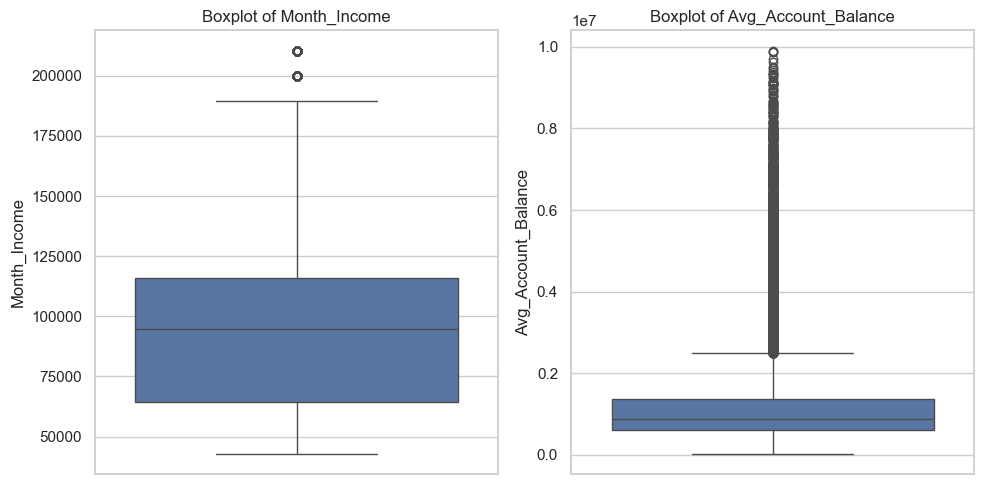

In [427]:
columns_with_outliers = ['Month_Income', 'Avg_Account_Balance']

plt.figure(figsize=(10, 5))

for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(1, len(columns_with_outliers), i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    
plt.tight_layout()
plt.show()

In [428]:
# Cap outliers in 'Avg_Account_Balance'
# df['Avg_Account_Balance'] = df['Avg_Account_Balance'].clip(lower=-546012.75, upper=2497021.25)

In [429]:
#selecting categorical columns

categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
categorical_cols

['Gender', 'Occupation', 'Loan_Status', 'Account_Category', 'Lead_Outcome']

In [430]:
#selecting numerical columns

numerical_cols = df.select_dtypes(include=['float64','int64']).columns.to_list()
numerical_cols

['Month_Income',
 'Age',
 'Credit_Score',
 'Existing_Credit_Cards',
 'Avg_Account_Balance',
 'Tenure_with_Bank']

In [431]:
for column in categorical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

        Count  Percentage
Gender                   
Male    47376   53.749021
Female  40767   46.250979
----------------------------------------
               Count  Percentage
Occupation                      
Self_Employed  34941   39.641265
Salaried       27649   31.368345
Other          24927   28.280181
Entrepreneur     626    0.710210
----------------------------------------
             Count  Percentage
Loan_Status                   
No           58530   66.403458
Yes          29613   33.596542
----------------------------------------
                  Count  Percentage
Account_Category                   
X1                40986   46.499438
X2                22780   25.844367
X3                22393   25.405307
X4                 1984    2.250888
----------------------------------------
              Count  Percentage
Lead_Outcome                   
No            54485   61.814324
Yes           33658   38.185676
----------------------------------------


In [432]:
for column in numerical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

              Count  Percentage
Month_Income                   
107050.0       7872    8.930942
85640.0        7855    8.911655
74935.0        7793    8.841315
42820.0        7789    8.836777
96345.0        7749    8.791396
53525.0        7714    8.751688
64230.0        7713    8.750553
136825.0       2459    2.789785
210500.0       2446    2.775036
126300.0       2441    2.769363
147350.0       2436    2.763691
199975.0       2434    2.761422
189450.0       2417    2.742135
84200.0        2398    2.720579
105250.0       2397    2.719445
73675.0        2395    2.717175
168400.0       2393    2.714906
157875.0       2390    2.711503
178925.0       2377    2.696754
94725.0        2342    2.657046
115775.0       2333    2.646835
----------------------------------------
     Count  Percentage
Age                   
28    5905    6.699341
29    5336    6.053799
27    5228    5.931271
30    4288    4.864822
26    3631    4.119442
..     ...         ...
81     263    0.298379
82     248    0.

Handle the imbalance columns

In [433]:
def categorize_tenure(value):
    if value in [1, 2, 3, 4]:
        return value
    elif value >= 5 and value <=10:
        return '5-10'
    elif value >= 10:
        return '10+'

# Apply the function to create a new column with categorized values
df['Tenure_with_Bank_Categorized'] = df['Tenure_with_Bank'].apply(categorize_tenure)

# Update the original column with the new categorized values
df['Tenure_with_Bank'] = df['Tenure_with_Bank_Categorized']

# Drop the temporary column
df.drop(columns=['Tenure_with_Bank_Categorized'], inplace=True)

print(df['Tenure_with_Bank'].value_counts())

Tenure_with_Bank
5-10    29355
10+     15200
1       10932
3       10912
2       10889
4       10855
Name: count, dtype: int64


In [434]:
# handling Existing_Credit_Cards
df['Existing_Credit_Cards'] = df['Existing_Credit_Cards'].apply(lambda x: 0 if x == 0 else 1)

print(df['Existing_Credit_Cards'].value_counts())

Existing_Credit_Cards
0    58530
1    29613
Name: count, dtype: int64


In [435]:
# # Define Loan_Status as the target to be balanced
# ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# # Resample based on Loan_Status
# X_res, y_res = ros.fit_resample(df.drop('Loan_Status', axis=1), df['Loan_Status'])

# # Combine the resampled target back with the original features
# df_resampled = pd.concat([pd.DataFrame(X_res, columns=df.drop('Loan_Status', axis=1).columns), pd.DataFrame(y_res, columns=['Loan_Status'])], axis=1)

# print(df_resampled['Loan_Status'].value_counts())

Exploratory Data Analysis (EDA)


In [436]:
print("\nStatistical summary of the dataset")
df.describe()


Statistical summary of the dataset


,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance
count,88143.000000,88143.000000,88143.000000,88143.000000,8.814300e+04
mean,100736.196068,42.835710,598.672952,0.335965,1.122263e+06
std,45184.678330,14.893035,179.940523,0.472330,8.656068e+05
min,42820.000000,24.000000,300.000000,0.000000,2.259700e+04
25%,64230.000000,29.000000,441.000000,0.000000,5.951250e+05
50%,94725.000000,41.000000,583.000000,0.000000,8.833420e+05
75%,115775.000000,53.000000,767.000000,1.000000,1.355884e+06
max,210500.000000,85.000000,900.000000,1.000000,9.908858e+06


In [437]:
sns.set(style="whitegrid")

# Function to plot distributions
def plot_distribution(column):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, data=df, palette='viridis')
        plt.title(f'Distribution of {column}')
    else:
        sns.histplot( df[column], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


# Function to plot count plot by target
def plot_by_target(column, target_column='Lead_Outcome'):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, hue=target_column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    else:
        sns.boxplot(x=target_column, y=column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    plt.xlabel(column)
    plt.ylabel('Count' if df[column].dtype == 'object' else column)
    plt.show()

Gender

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


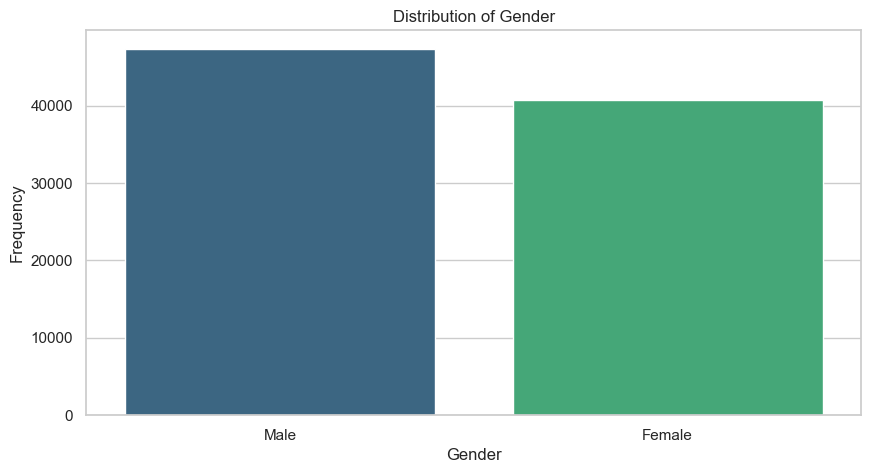

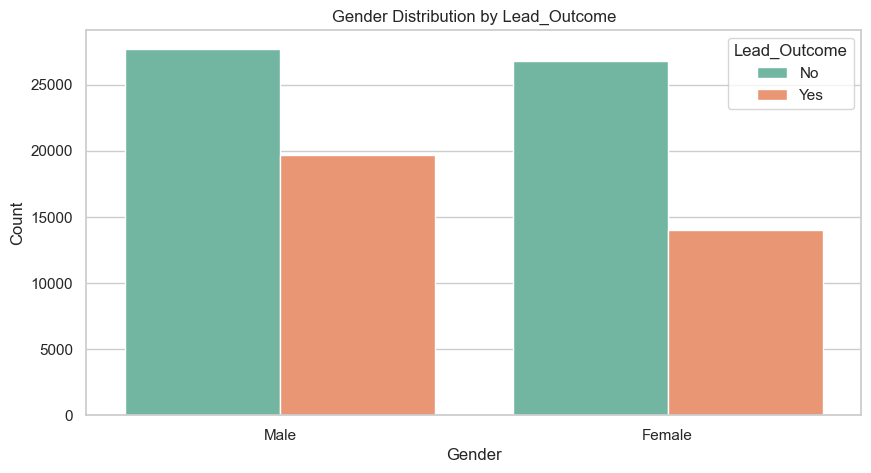

In [438]:
plot_distribution('Gender')
plot_by_target('Gender')

Month_Income

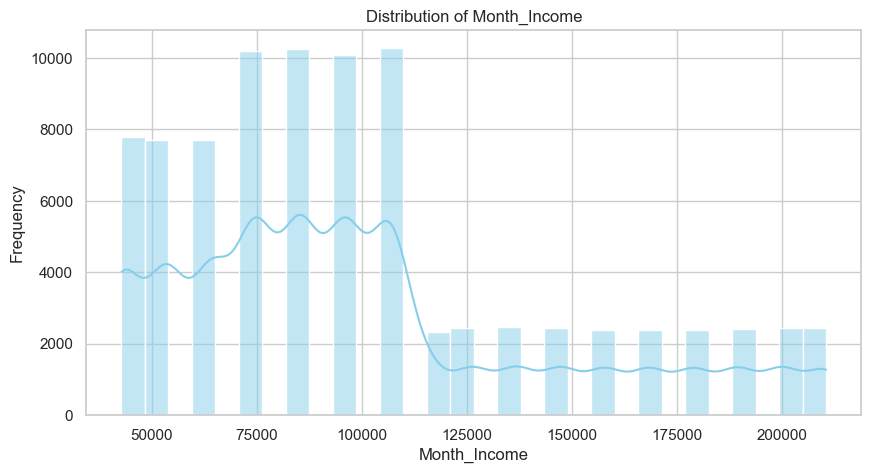

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


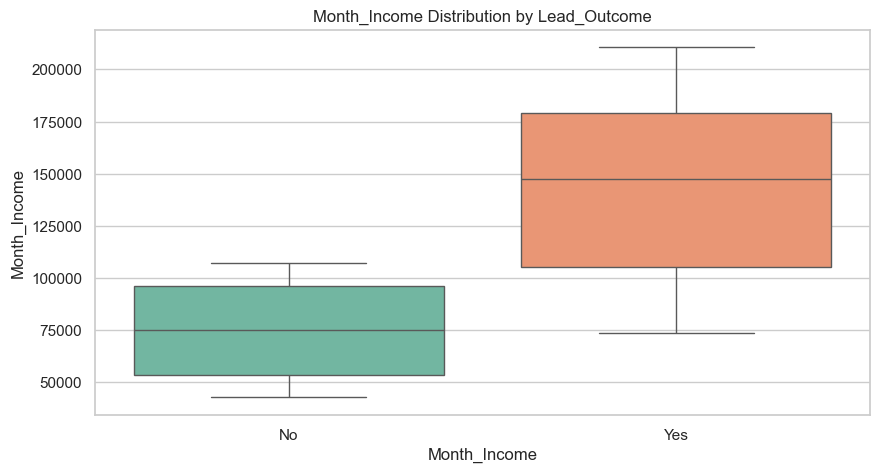

In [439]:
plot_distribution('Month_Income')
plot_by_target('Month_Income')

Age

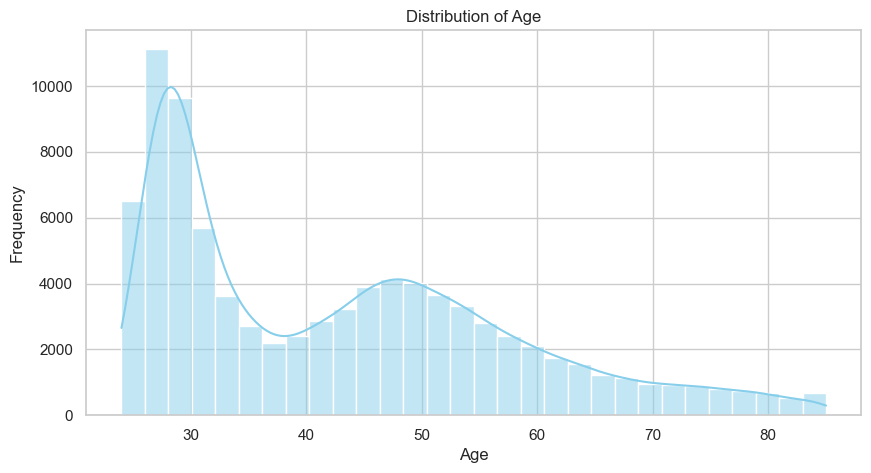

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


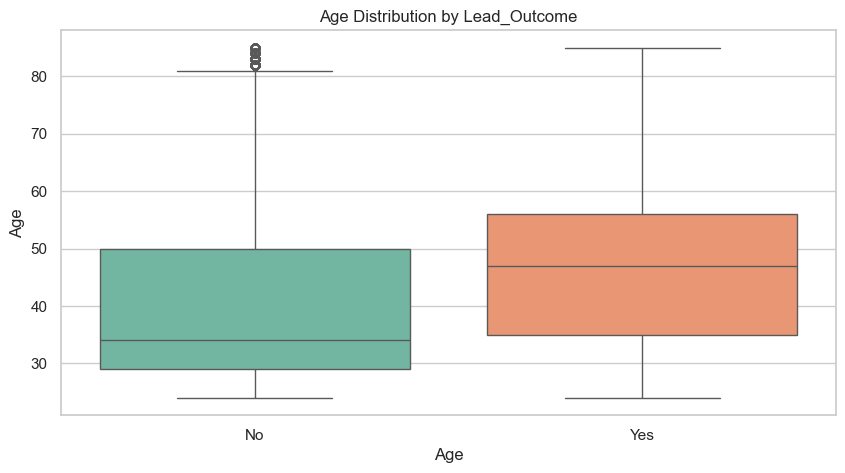

In [440]:
plot_distribution('Age')
plot_by_target('Age')

Occupation

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


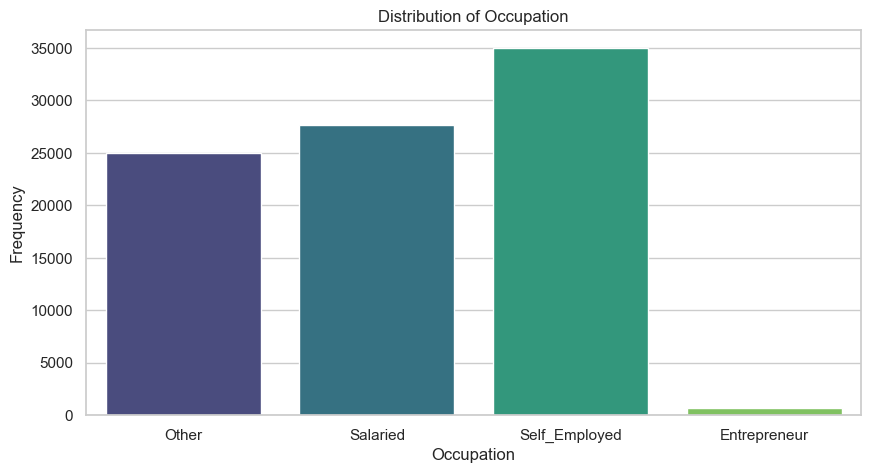

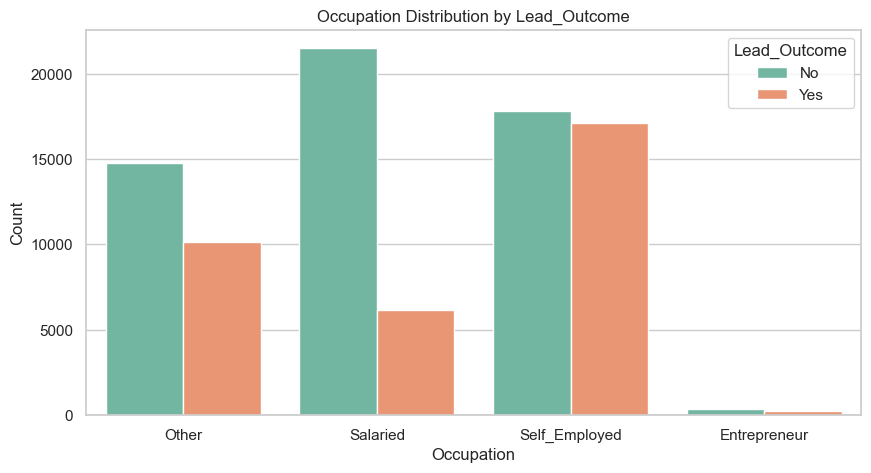

In [441]:
plot_distribution('Occupation')
plot_by_target('Occupation')

Loan_Status

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


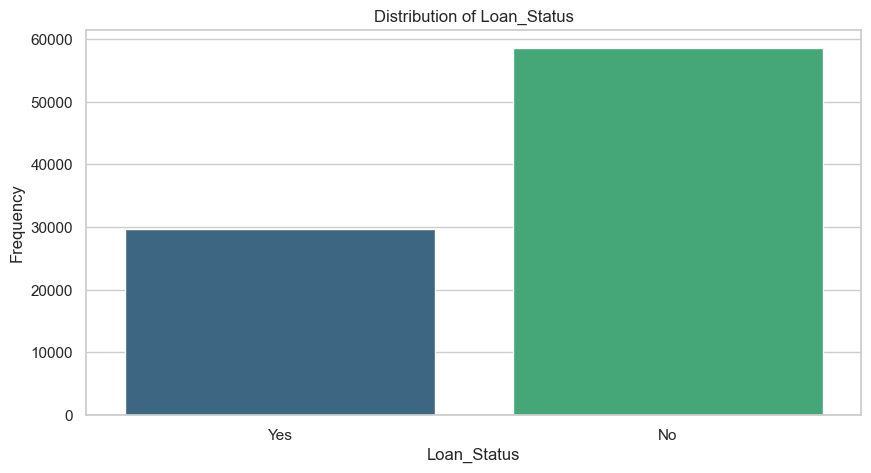

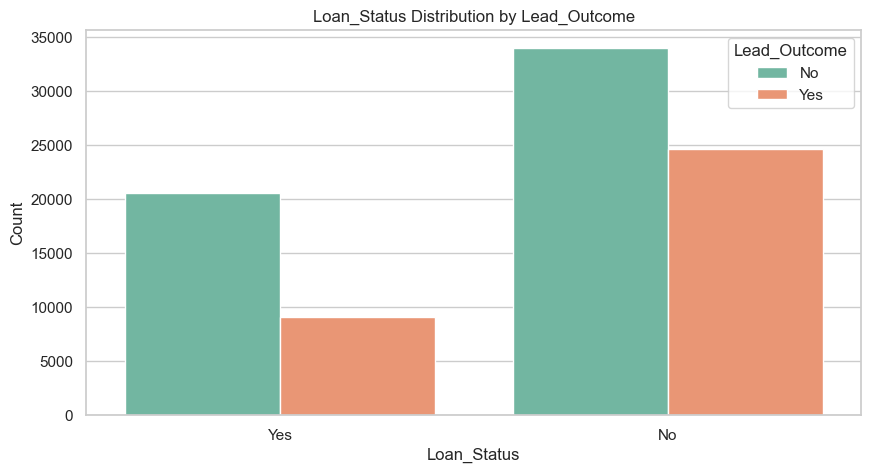

In [442]:
plot_distribution('Loan_Status')
plot_by_target('Loan_Status')

Existing_Credit_Cards

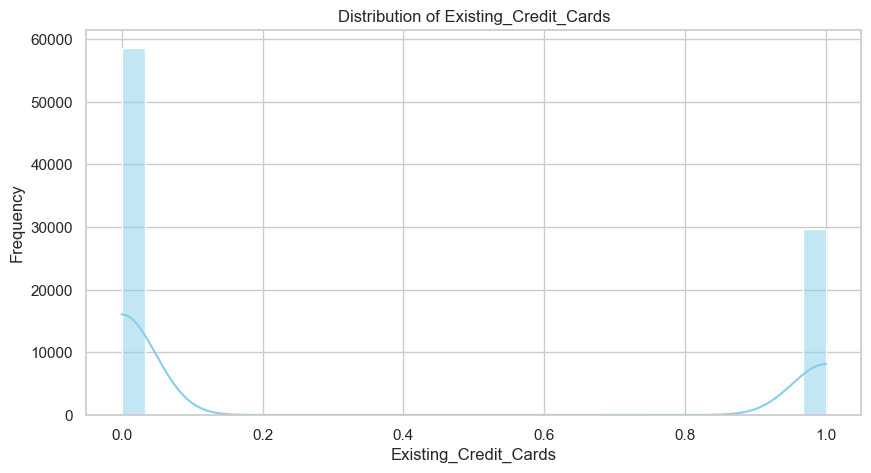

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


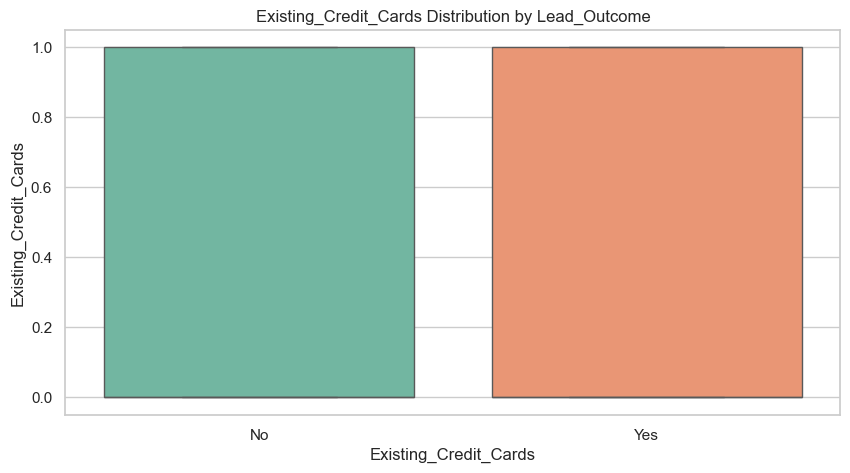

In [443]:
plot_distribution('Existing_Credit_Cards')
plot_by_target('Existing_Credit_Cards')

Account_Category

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


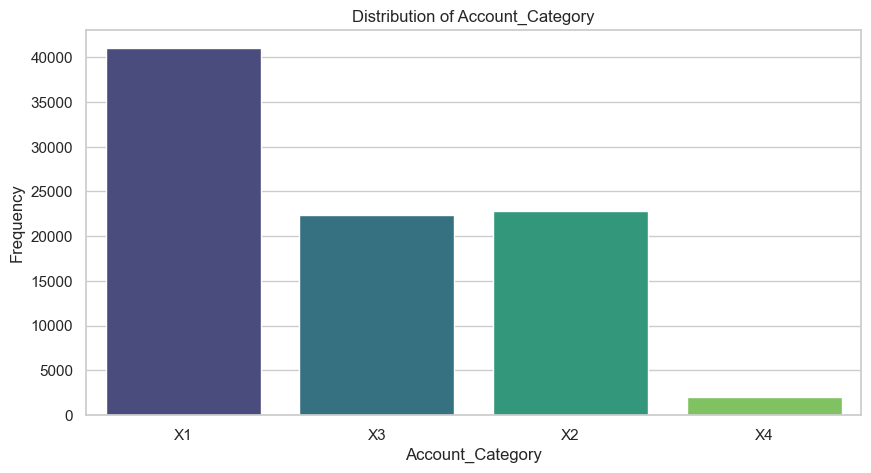

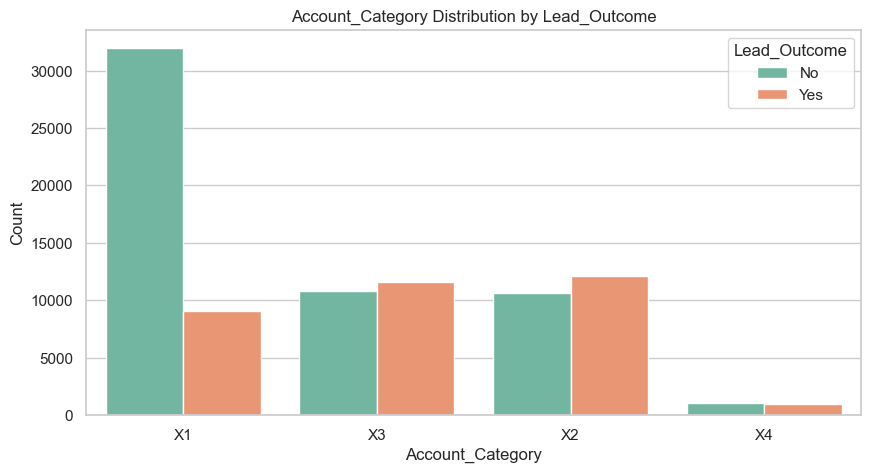

In [444]:
plot_distribution('Account_Category')
plot_by_target('Account_Category')

Tenure_with_Bank

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


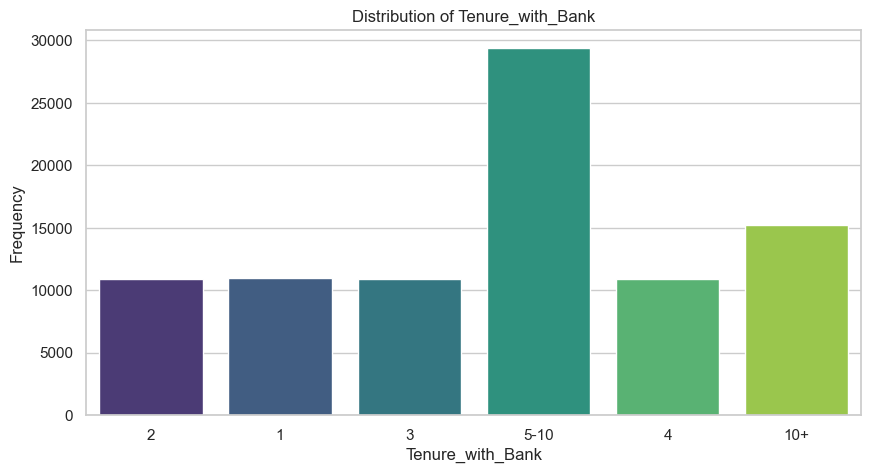

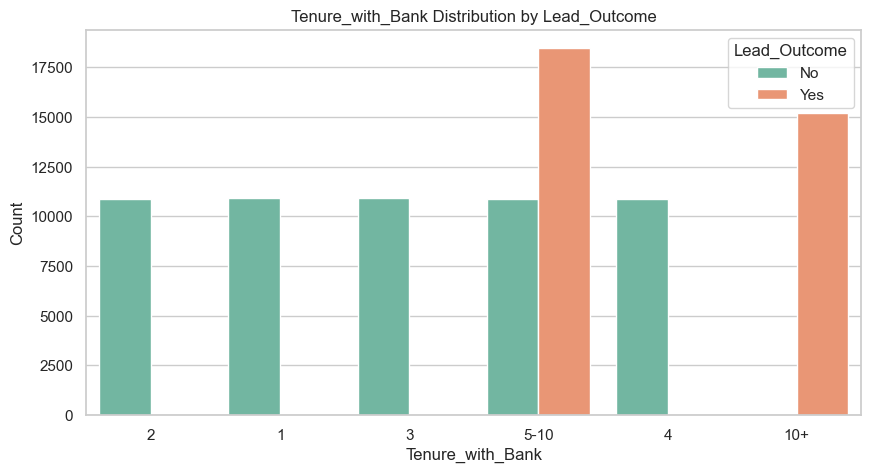

In [445]:
plot_distribution('Tenure_with_Bank')
plot_by_target('Tenure_with_Bank')

Lead_Outcome

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


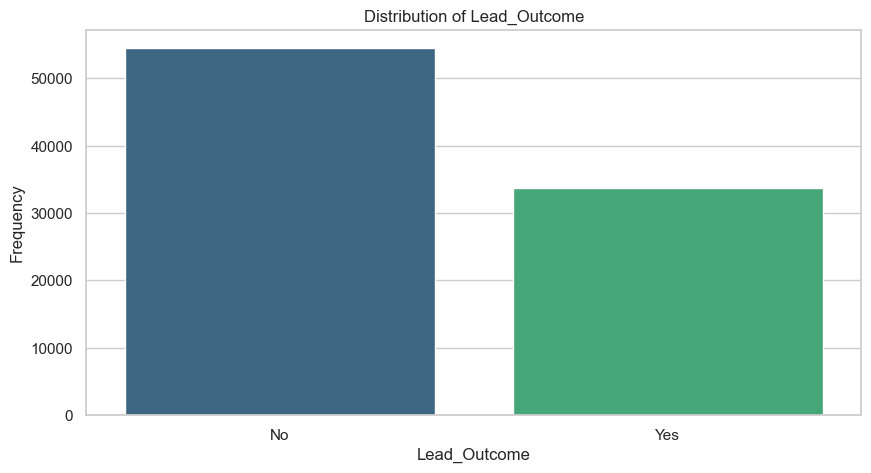

In [446]:
plot_distribution('Lead_Outcome')

Encoding the columns 

In [447]:
# #Convert categorical features into numerical values

# # Initialize the LabelEncoder
# label_encoders = {}
# for col in categorical_cols:
#     label_encoder = LabelEncoder()
#     df[col] = label_encoder.fit_transform(df[col])
#     label_encoders[col] = label_encoder

#     # Display mapping for this column
#     print(f"\nMapping for {col}:")
#     for class_index, class_label in enumerate(label_encoder.classes_):
#         print(f"{class_label}: {class_index}")

df['Lead_Outcome']=df['Lead_Outcome'].apply(lambda x : 1 if x=='Yes' else 0) 
df = pd.get_dummies(df)
print(df.columns)

Index(['Month_Income', 'Age', 'Credit_Score', 'Existing_Credit_Cards',
       'Avg_Account_Balance', 'Lead_Outcome', 'Gender_Female', 'Gender_Male',
       'Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Loan_Status_No', 'Loan_Status_Yes',
       'Account_Category_X1', 'Account_Category_X2', 'Account_Category_X3',
       'Account_Category_X4', 'Tenure_with_Bank_1', 'Tenure_with_Bank_2',
       'Tenure_with_Bank_3', 'Tenure_with_Bank_4', 'Tenure_with_Bank_10+',
       'Tenure_with_Bank_5-10'],
      dtype='object')


In [448]:
df.head()

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Lead_Outcome,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,...,Account_Category_X1,Account_Category_X2,Account_Category_X3,Account_Category_X4,Tenure_with_Bank_1,Tenure_with_Bank_2,Tenure_with_Bank_3,Tenure_with_Bank_4,Tenure_with_Bank_10+,Tenure_with_Bank_5-10
0,96345.0,29,623,1,742366,0,False,True,False,True,...,True,False,False,False,False,True,False,False,False,False
2,96345.0,31,357,0,215949,0,False,True,False,False,...,True,False,False,False,True,False,False,False,False,False
3,85640.0,29,356,0,868070,0,False,True,False,True,...,True,False,False,False,False,False,True,False,False,False
4,42820.0,29,572,0,657087,0,True,False,False,True,...,True,False,False,False,False,False,True,False,False,False
5,64230.0,60,478,0,4624262,0,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True


Train the model

In [449]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

X = df.drop('Lead_Outcome', axis=1).values  # Features
y = df['Lead_Outcome'].values  # Target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [450]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize models
models = {
    'Random Forest': (RandomForestClassifier(), param_grid_rf, GridSearchCV),
    'Logistic Regression': (LogisticRegression(class_weight='balanced'), param_grid_lr, GridSearchCV),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, RandomizedSearchCV)
}

In [451]:
# Perform hyperparameter tuning with K-Fold Cross Validation
best_models = {}

for name, (model, param_grid, search_method) in models.items():
    print("-" * 100)
    print(f"Starting hyperparameter tuning for {name}...")
    
    # For GridSearchCV or RandomizedSearchCV based on the model
    if search_method == GridSearchCV:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2)
    else:
        grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=kfold, n_jobs=-1, verbose=2, random_state=42)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")
    print("-" * 100)
    
    best_models[name] = grid_search.best_estimator_

----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score for Logistic Regression: 0.8970340356564019
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score for XGBoost: 0.9999837925445705
----------------------------------------------------------------------------------------------------


In [452]:
# Evaluate the tuned models
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        print(f'\nPerformance Report for {name} (Tuned):\n')
        
        # Predict the outcomes
        y_pred = model.predict(X_test)
        
        # Compute and print accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.4f}')

        # Compute and print classification report
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

# Call the function to evaluate the best models
evaluate_models(best_models, X_test, y_test)


Performance Report for Random Forest (Tuned):

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16358
           1       1.00      1.00      1.00     10085

    accuracy                           1.00     26443
   macro avg       1.00      1.00      1.00     26443
weighted avg       1.00      1.00      1.00     26443


Performance Report for Logistic Regression (Tuned):

Accuracy: 0.9129
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.93     16358
           1       0.83      0.98      0.90     10085

    accuracy                           0.91     26443
   macro avg       0.91      0.93      0.91     26443
weighted avg       0.92      0.91      0.91     26443


Performance Report for XGBoost (Tuned):

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00    

Test MAE, MSE, and R² for Logistic Regression

In [453]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = best_models['Logistic Regression'].predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.08709299247437885
Mean Squared Error: 0.08709299247437885


Save the model


In [454]:
import joblib

# Save the model
joblib.dump(best_models['Logistic Regression'], '../TrainedModels/credit_card_lead_prediction_model.pkl')

['../TrainedModels/credit_card_lead_prediction_model.pkl']

In [455]:
# Load the model
loaded_model = joblib.load('../TrainedModels/credit_card_lead_prediction_model.pkl')

Make a prediction

In [472]:
import pandas as pd
import numpy as np

# Example new data
new_data = pd.DataFrame({
    'Gender': ['Male'],
    'Month_Income': [200000],
    'Age': [35],
    'Occupation': ['Entrepreneur'],
    'Credit_Score': [350],
    'Loan_Status': ['No'],
    'Existing_Credit_Cards': [2],
    'Avg_Account_Balance': [100000],
    'Account_Category': ['X1'],
    'Tenure_with_Bank': [1]
})

new_data_encoded = pd.get_dummies(new_data)

all_columns = df.columns.drop('Lead_Outcome') 
new_data = new_data_encoded.reindex(columns=all_columns, fill_value=0)


In [473]:
new_data

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,...,Account_Category_X1,Account_Category_X2,Account_Category_X3,Account_Category_X4,Tenure_with_Bank_1,Tenure_with_Bank_2,Tenure_with_Bank_3,Tenure_with_Bank_4,Tenure_with_Bank_10+,Tenure_with_Bank_5-10
0,200000,35,350,2,100000,0,True,True,0,0,...,True,0,0,0,0,0,0,0,0,0


In [474]:
# Make predictions
predictions = loaded_model.predict(new_data)

predictions = ['Yes' if pred == 1 else 'No' for pred in predictions]

print(f'Predicted Lead Outcome: {predictions[0]}')


Predicted Lead Outcome: Yes


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
